## 📖 Background
You work for the human capital department of a large corporation. The Board is worried about the relatively high turnover, and your team must look into ways to reduce the number of employees leaving the company.

The team needs to understand better the situation, which employees are more likely to leave, and why. Once it is clear what variables impact employee churn, you can present your findings along with your ideas on how to attack the problem.

💪 **Competitive challenge**

Which department has the highest employee turnover? Which one has the lowest?

Investigate which variables seem to be better predictors of employee departure.

What recommendations would you make regarding ways to reduce employee turnover?

## 💾 The data & load packages
The department has assembled data on almost 10,000 employees. The team used information from exit interviews, performance reviews, and employee records.

- "department" - the department the employee belongs to.
- "promoted" - 1 if the employee was promoted in the previous 24 months, 0 otherwise.
- "review" - the composite score the employee received in their last evaluation.
- "projects" - how many projects the employee is involved in.
- "salary" - for confidentiality reasons, salary comes in three tiers: low, medium, high.
- "tenure" - how many years the employee has been at the company.
- "satisfaction" - a measure of employee satisfaction from surveys.
- "avg_hrs_month" - the average hours the employee worked in a month.
- "left" - "yes" if the employee ended up leaving, "no" otherwise.

In [2]:
import pandas as pd
df = pd.read_csv('./data/employee_churn_data.csv')
df.head(3)

,department,promoted,review,projects,salary,tenure,satisfaction,bonus,avg_hrs_month,left
0,operations,0,0.577569,3,low,5.0,0.626759,0,180.866070,no
1,operations,0,0.751900,3,medium,6.0,0.443679,0,182.708149,no
2,support,0,0.722548,3,medium,6.0,0.446823,0,184.416084,no


In [3]:
# Read data
import pandas as pd

# Visualize data
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
%matplotlib inline 

# warnings ignore
import warnings
warnings.filterwarnings('ignore')

# data processing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, plot_roc_curve
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV


# Configure visualizations
plt.rcParams['figure.figsize'] = [12, 6]
sns.set_theme(style="white", context="talk")

## 1. Exploratory data analysis

#### 1.1 Checking for missing and duplicate values 

In [4]:
# Information on datasets and change dtypes
df['department'] = df['department'].astype('category')
df['salary'] = df['salary'].astype('category')
df.info()
df.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9540 entries, 0 to 9539
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   department     9540 non-null   category
 1   promoted       9540 non-null   int64   
 2   review         9540 non-null   float64 
 3   projects       9540 non-null   int64   
 4   salary         9540 non-null   category
 5   tenure         9540 non-null   float64 
 6   satisfaction   9540 non-null   float64 
 7   bonus          9540 non-null   int64   
 8   avg_hrs_month  9540 non-null   float64 
 9   left           9540 non-null   object  
dtypes: category(2), float64(4), int64(3), object(1)
memory usage: 615.5+ KB


0

**There no missing or duplicate values in the dataset.**

In [5]:
# Summary descriptive statistics of dataset
df.describe()

,promoted,review,projects,tenure,satisfaction,bonus,avg_hrs_month
count,9540.000000,9540.000000,9540.000000,9540.000000,9540.000000,9540.000000,9540.000000
mean,0.030294,0.651826,3.274843,6.556184,0.504645,0.212055,184.661571
std,0.171403,0.085307,0.579136,1.415432,0.158555,0.408785,4.144831
min,0.000000,0.310000,2.000000,2.000000,0.000000,0.000000,171.374060
25%,0.000000,0.592884,3.000000,5.000000,0.386801,0.000000,181.472085
50%,0.000000,0.647456,3.000000,7.000000,0.500786,0.000000,184.628796
75%,0.000000,0.708379,4.000000,8.000000,0.622607,0.000000,187.728708
max,1.000000,1.000000,5.000000,12.000000,1.000000,1.000000,200.861656


#### 1.2 Exploring distribution and pair relationships

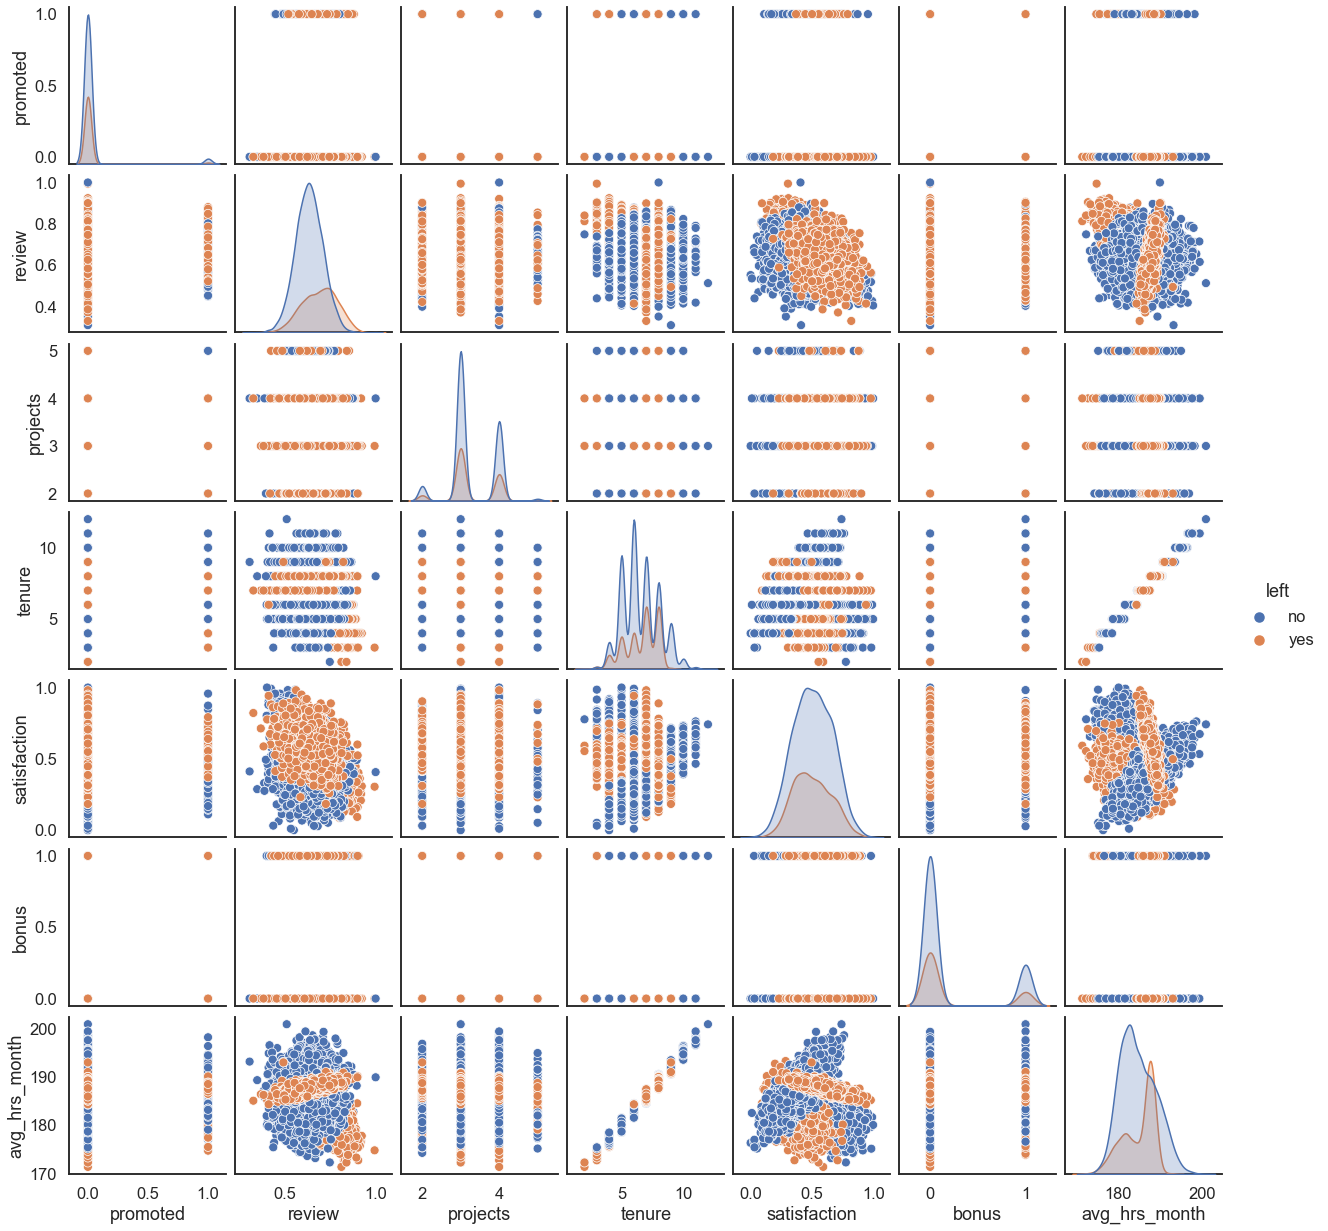

In [6]:
# distribution of functions and relationships between pairs
sns.pairplot(data=df, hue="left")

In some pair relationships, it is possible to observe the formation of clusters. Especially in satisfaction, review and tenure. These relationships will be interesting to explore further.

<AxesSubplot:>

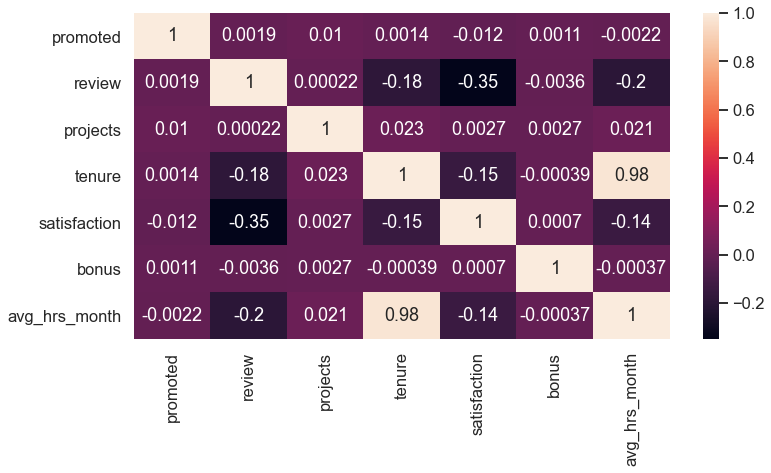

In [7]:
# Heatmap with the numeric values
sns.heatmap(df.corr(), annot=True)

##### Summary:
- **Tenure correlates highly with avg_hrs_mouth.** Both features bring the same information to the model.
- There is also a slight **inverse relationship between employee satisfaction and employer review.**

## 2. Research questions

#### 2.1 Which department has the highest employee turnover? Which one has the lowest?

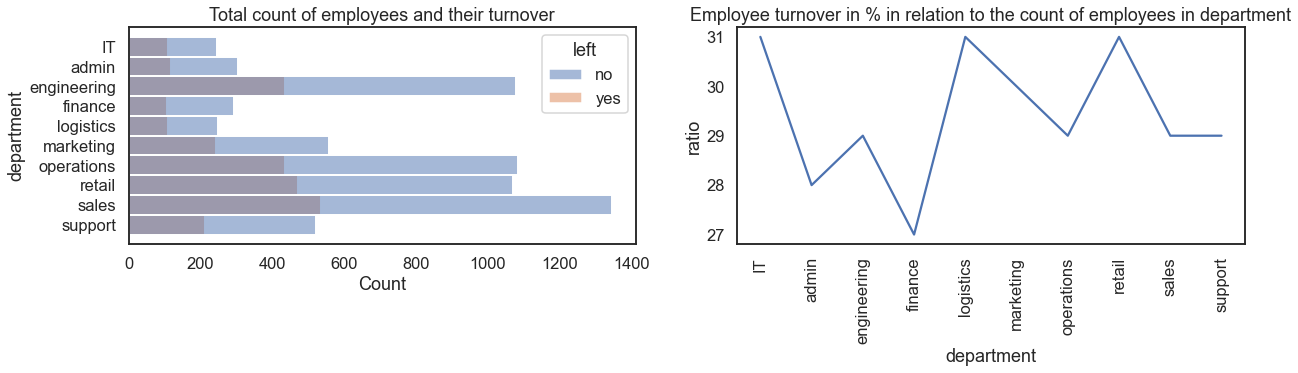

In [8]:
# Data preparation
subset = df[df['left'] == 'yes']
s = pd.DataFrame(df.groupby(['department'])['left'].count())
t = pd.DataFrame(subset.groupby(['department'])['left'].count())
x = s.merge(t, on="department", suffixes=('_total', '_yes'))
x['ratio'] = round((x['left_yes'] / x['left_total']) * 100)

f, axs = plt.subplots(1, 2, figsize=(20, 4), gridspec_kw=dict(width_ratios=[4, 4]))
# Number of employees in departments / number of employees turnover 
h = sns.histplot(data=df, y="department", hue="left", legend=True, ax=axs[0])
h.set_title("Total count of employees and their turnover")

# % of employees turnover in relation to the total count employees in dept
g = sns.lineplot(data=x, y="ratio", x='department', ax=axs[1])
g.set_title("Employee turnover in % in relation to the count of employees in department")
g = plt.xticks(rotation=90)


#### Summary
- The departments with the highest count of employees have the highest turnover: sales, engineering, operations and retail. In relation to the total count of employees in the department, there is **the highest turnover in the IT, logistics and retail departments.**
- **The lowest turnover rate** is in the departments **finance and admin**.
- Turnover of employees of all departments is in the range of 27-31 %. **For employees who left, it wasn't important what department they were from.**

#### 2.2 What could have been the reasons for employees turnover?

Let's look at employee satisfaction over time. And also on the review of the employer over time.

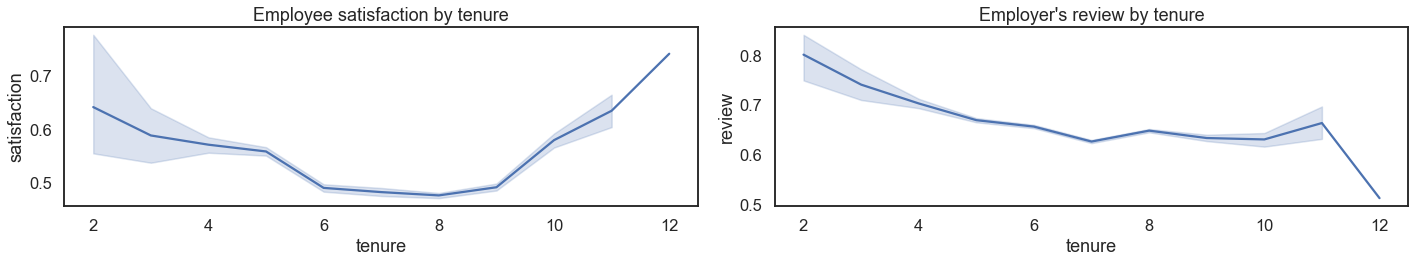

In [9]:
f, axs = plt.subplots(1, 2, figsize=(20, 4), gridspec_kw=dict(width_ratios=[4, 4]))
t = sns.lineplot(data=df, x="tenure", y="satisfaction", ax=axs[0])
t.set_title("Employee satisfaction by tenure")
s = sns.lineplot(data=df, x="tenure", y="review", ax=axs[1])
s.set_title("Employer's review by tenure")
f.tight_layout()

- Employee **satisfaction decreases significantly from 6 to 8 years.**
- The employer's review decreases slightly with tenure. But there are no major changes.

Let's see what the comparison will look like for employees who stayed and who left.

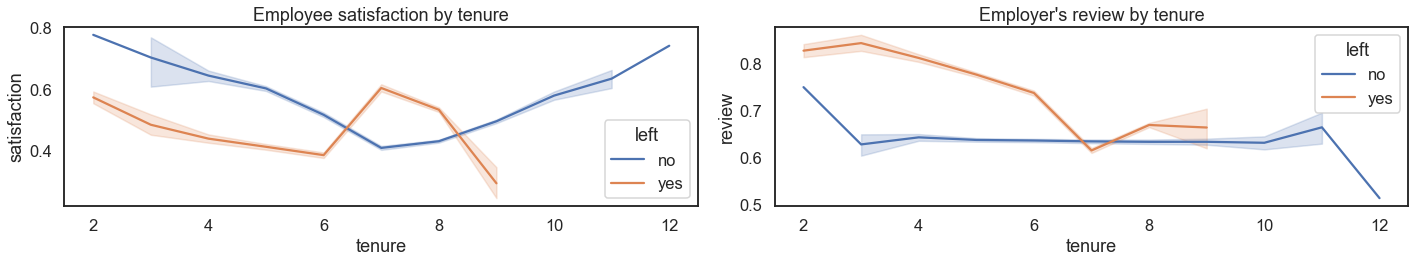

In [10]:
f, axs = plt.subplots(1, 2, figsize=(20, 4), gridspec_kw=dict(width_ratios=[4, 4]))
t = sns.lineplot(data=df, x="tenure", y="satisfaction", hue="left", ax=axs[0])
t.set_title("Employee satisfaction by tenure")
s = sns.lineplot(data=df, x="tenure", y="review", hue="left", ax=axs[1])
s.set_title("Employer's review by tenure")
f.tight_layout()

- Here we can see that **the employees who left had lower satisfaction. But employees with a tenure for 6-8 years left regardless of their satisfaction.** During this period, the employees who did not leave are also less satisfied.
- In the employer's review, it is clear that **employees with a high rating have left.** The employer values his employees highly, but does not care about their satisfaction.
- With tenure 6-8 years the employer's review declined and during this period most employees also left.

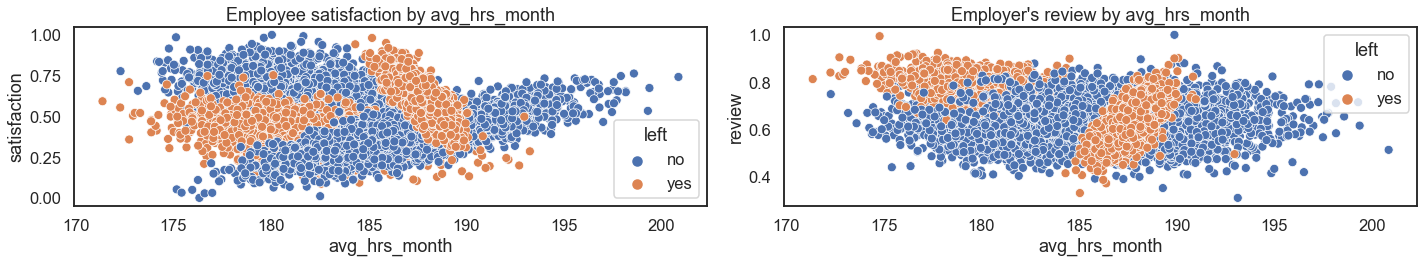

In [11]:
f, axs = plt.subplots(1, 2, figsize=(20, 4), gridspec_kw=dict(width_ratios=[4, 4]))
t = sns.scatterplot(data=df, x="avg_hrs_month", y="satisfaction", hue="left", ax=axs[0])
t.set_title("Employee satisfaction by avg_hrs_month")
s = sns.scatterplot(data=df, x="avg_hrs_month", y="review", hue="left", ax=axs[1])
s.set_title("Employer's review by avg_hrs_month")
f.tight_layout()

In the avg_hrs_month relationship, we see two groups in employee satisfaction and employer review:
- **Employees often left with avg_hrs_month in the range of 185 - 190 hours.**
- Also employees highly rated by the employer with avg_hrs_month 170 - 183 hours left.

Text(0.5, 1.0, 'Total count of employees and their turnover by tenure')

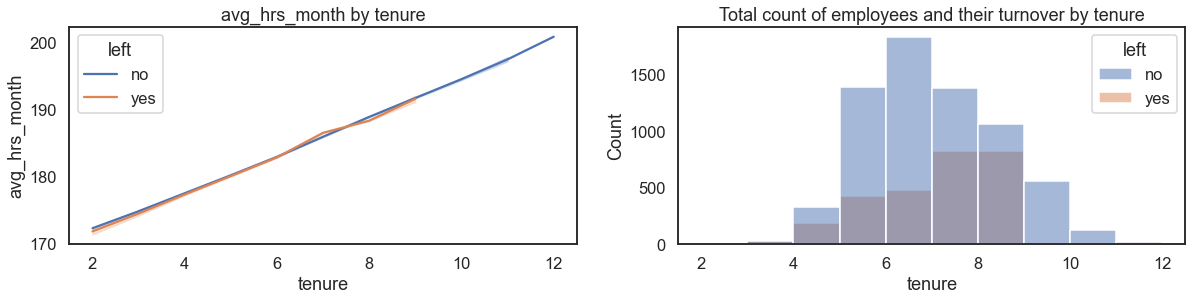

In [12]:
f, axs = plt.subplots(1, 2, figsize=(20, 4), gridspec_kw=dict(width_ratios=[4, 4]))
i = sns.lineplot(data=df, x="tenure", y="avg_hrs_month", hue="left", ax=axs[0])
i.set_title("avg_hrs_month by tenure")
p = sns.histplot(data=df, x="tenure", hue="left", legend=True, bins = 10, ax=axs[1])
p.set_title("Total count of employees and their turnover by tenure")

<AxesSubplot:xlabel='salary', ylabel='Count'>

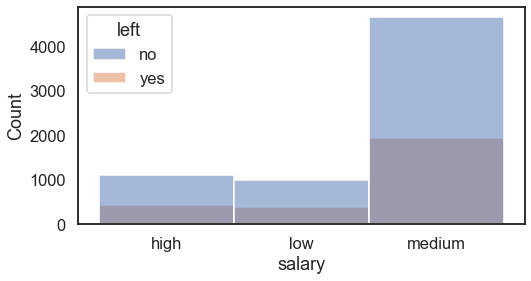

In [13]:
f, axs = plt.subplots(figsize=(8, 4))
sns.histplot(data=df, x="salary", hue="left")


- **The highest count of employees left for tenure 7-8 years.** For this tenure is avg_hrs_month in the range of 185 - 190 hours.
- The average monthly count of hours worked increases with the count of years worked.
- According to the amount of salary, the count of outgoing employees are adequate.

#### Summary
- The critical period of employment for employees occurs in the range of 6 - 8 years. During this period, employees leave regardless of their level of satisfaction and the employees who didn't leave are also less satisfied.
- Employees who have a higher employer rating seem to be more likely to leave.

It's already possible to trace certain contexts. We have more features at our disposal and we'll further evaluate the possibility of the employee leaving using classification models.


## 3. Selection of the most suitable predictors of employee turnover

The methods of classification models are used to evaluate the best predictors of employee turnover. Based on the EDA, the following functions have been evaluated for the use of classification models: 'promoted', 'review', 'projects', 'tenure','satisfaction', 'avg_hrs_month', 'bonus'

#### 3.1 Data preprocessing

We'll adjust the data so that they are all numeric. We'll select a subset of features that could affect the resulting classification. We split the data into target and data for processing. Use train_test_split to split data for training and testing.

In [14]:
# transformation to numeric values
df['left'] = df['left'].replace("no", 0)
df['left'] = df['left'].replace("yes", 1)
# creating subset
df_sub = df[['promoted','review', 'projects', 'tenure','satisfaction','avg_hrs_month', 'bonus']]

# data standardization
scaler = StandardScaler()
df_std = scaler.fit_transform(df_sub)

# Creating data
X = df_std

# Selecting column 'left' as the feature to be predicted (y)
y = df['left']

# Split data 70% train and 30% test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

print("{} rows in test set vs. {} in training set. {} Features.".format(X_test.shape[0], X_train.shape[0], X_test.shape[1]))

2862 rows in test set vs. 6678 in training set. 7 Features.


#### 3.3 Logistic Regression
Logistic regression is the basic machine learning model for binary classification. We'll use it in the pipeline. Before classification, we standardize the data using StandardScaler and reduce it using PCA.

In [19]:
# model initiation LogisticRegression
lr = LogisticRegression()

# Logistic regression model on the scaled training data
lr.fit(X_train, y_train)

# Predict test set
y_pred = lr.predict(X_test)

# Printing accuracy metrics and feature coefficients
print("Accuracy: {0:.1%}".format(accuracy_score(y_test, y_pred)))
print(dict(zip(df_sub.columns, abs(lr.coef_[0]).round(2))))

Accuracy: 73.4%
{'promoted': 0.11, 'review': 0.98, 'projects': 0.05, 'tenure': 0.02, 'satisfaction': 0.43, 'avg_hrs_month': 0.27, 'bonus': 0.0}


For LogisticRegression are the best predictors of employee leaving: review 0.95, satisfaction: 0.41 and avg_hrs_month: 0.19. Accuracy is not too high. Let's look at the classification using RandomForestClassifier.

#### 3.4 RandomForestClassifier

In [18]:
# Create a RandomForestClassifier
rf = RandomForestClassifier(random_state=0)

# Train the random forest 
rf.fit(X_train, y_train)

# Printing accuracy metrics
acc = accuracy_score(y_test, rf.predict(X_test))

print(dict(zip(df_sub.columns, rf.feature_importances_.round(2))))
print("Accuracy: {0:.1%}".format(acc))

{'promoted': 0.0, 'review': 0.29, 'projects': 0.02, 'tenure': 0.08, 'satisfaction': 0.32, 'avg_hrs_month': 0.28, 'bonus': 0.01}
Accuracy: 86.8%


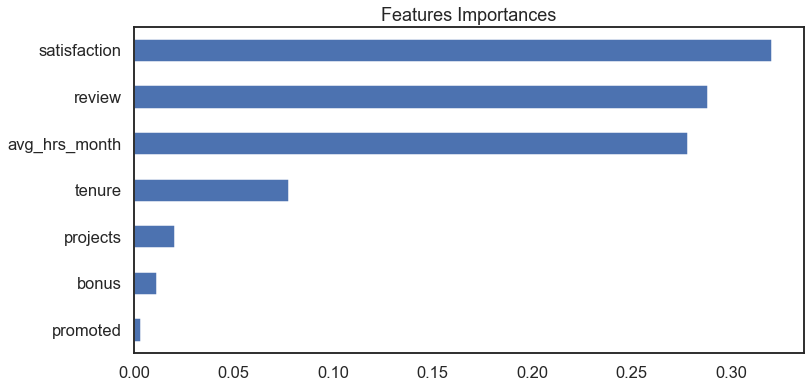

In [17]:
# Create a sorted Series of features importances
importances_sorted = pd.Series(
    data=rf.feature_importances_, index=df_sub.columns
).sort_values()

# Plot a horizontal barplot of importances_sorted
importances_sorted.plot(kind="barh")
plt.title("Features Importances")
plt.show()

For RandomForestClassifier are the best predictors of employee leaving: satisfaction: 0.31, review 0.29, avg_hrs_month: 0.28. Accuracy is higher than logreg and is favorable. 

## 4. Conclusion

- An important criterion for an employee's probable departure is his low job satisfaction.
- Also important is the level of review from the employer, it turned out that employees highly rated are likely to leave.
- The ever-increasing avg_hrs_month is also adversely affecting employees. Not all employees welcome and leave the ever-increasing number of hours at work.

# 🏆 Recommendations for reducing employee turnover 👀

- the employer shouldn't be satisfied that his employee has a high review, he should listen more to his employees and act on the feedback from the employee if he isn't satisfied
- much attention in the satisfaction survey to pay to employees who have been in the company for more than 5 years
- enable employees to work-life-balance. Thus, to help make work more efficient for employees so that their number of hours at work does not increase.

**Thanks for reading!**

(c) Zdenka Kynychova, Feb 2022